Spectrogram saved to usable_spectrogram.png


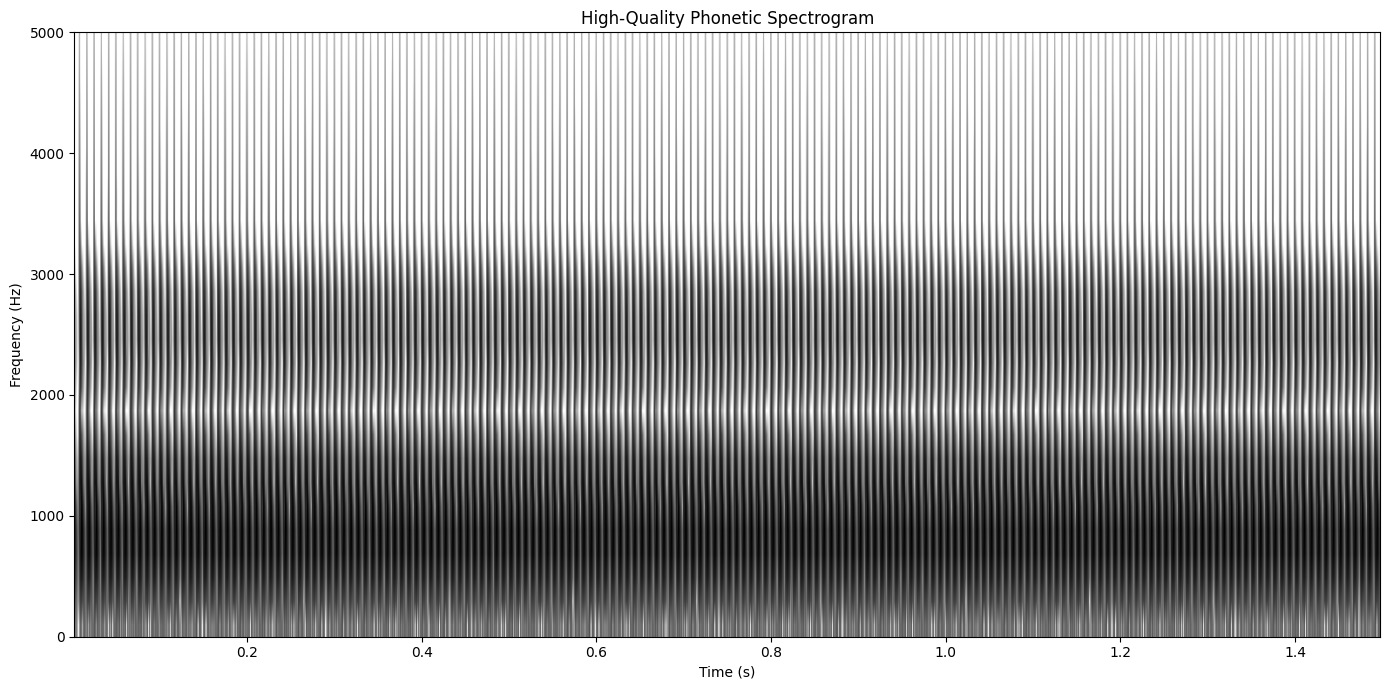

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy.signal import spectrogram as scipy_spectrogram, windows, lfilter

def generate_phonetic_spectrogram(
    audio_path,
    output_path=None,
    freq_range=(0, 5000),
    window_length=0.005,
    dynamic_range=50,
    dynamic_compression=0.3, # This is the new, critical parameter
    pre_emphasis_from=50
):
    """
    Generates and saves a high-quality, Praat-like spectrogram
    optimized for phonetic analysis.

    Args:
        audio_path (str): Path to the WAV audio file.
        output_path (str, optional): Path to save the spectrogram image. If None, displays the plot.
        freq_range (tuple, optional): The frequency range (min, max) to display in Hz.
        window_length (float, optional): The length of the analysis window in seconds.
        dynamic_range (int, optional): The dynamic range in dB to display.
        dynamic_compression (float, optional): A value between 0 and 1 for compressing the
                                             dynamic range. 0 is linear, 1 is max compression.
                                             0.3 is a good starting point.
        pre_emphasis_from (int, optional): The frequency from which to apply pre-emphasis.
    """
    try:
        sample_rate, samples = wavfile.read(audio_path)
        if samples.ndim > 1:
            samples = samples.mean(axis=1)

        # 1. Pre-emphasis
        k = np.exp(-2 * np.pi * pre_emphasis_from / sample_rate)
        emphasized_samples = lfilter([1, -k], 1, samples)

        # 2. Spectrogram Calculation (Praat's defaults)
        nperseg = int(window_length * sample_rate)
        hop_length = int(0.001 * sample_rate) # 1ms time step
        noverlap = nperseg - hop_length
        window = windows.gaussian(nperseg, std=nperseg / 8)

        frequencies, times, Sxx = scipy_spectrogram(
            emphasized_samples, fs=sample_rate, window=window,
            nperseg=nperseg, noverlap=noverlap, scaling='density'
        )

        # 3. Power and dB Conversion
        Sxx_db = 10 * np.log10(np.maximum(Sxx, 1e-10))

        # 4. ROBUST Dynamic Range Calculation
        # Use a percentile to find the "real" max, ignoring loud clicks.
        # This is a huge factor in creating a clean image.
        max_db = np.percentile(Sxx_db, 99.9)
        min_db = max_db - dynamic_range

        # Clip the spectrogram to the desired dynamic range
        clipped_Sxx_db = np.clip(Sxx_db, min_db, max_db)

        # 5. DYNAMIC COMPRESSION (The "Secret Sauce")
        # This non-linear mapping makes formants pop.
        # We scale the clipped values to be between 0 and 1, apply a power,
        # and then scale them back.
        normalized_Sxx = (clipped_Sxx_db - min_db) / dynamic_range
        compressed_Sxx = normalized_Sxx ** (1 - dynamic_compression)


        # 6. PLOTTING WITH IMSHOW for a smooth image
        fig, ax = plt.subplots(figsize=(14, 7))
        img = ax.imshow(
            compressed_Sxx,
            interpolation='bilinear', # Smoother than 'nearest'
            origin='lower',
            aspect='auto',
            extent=(times.min(), times.max(), frequencies.min(), frequencies.max()),
            cmap='gray_r' # Reversed grayscale for dark formants
        )

        ax.set_ylim(freq_range)
        ax.set_xlabel("Time (s)")
        ax.set_ylabel("Frequency (Hz)")
        ax.set_title("High-Quality Phonetic Spectrogram")
        plt.tight_layout()

        # No colorbar, as the compressed values are not directly interpretable as dB
        # The visual contrast is what matters for phonetic analysis.

        if output_path:
            plt.savefig(output_path, dpi=300)
            print(f"Spectrogram saved to {output_path}")
        else:
            plt.show()

    except FileNotFoundError:
        print(f"Error: The file at {audio_path} was not found.")
    except Exception as e:
        print(f"An error occurred: {e}")

# --- Example Usage ---
# Using the synthesized vowel from the previous example
from scipy.io.wavfile import write

sr = 22050
duration = 1.5
f0 = 120
t = np.linspace(0., duration, int(sr * duration))
harmonics = np.zeros_like(t)
for i in range(1, int(sr / (2 * f0))):
    harmonics += (1 / i) * np.sin(2. * np.pi * f0 * i * t)

def formant_filter(x, F1, F2, F3):
    from scipy.signal import butter, lfilter
    nyquist = 0.5 * sr
    b, a = butter(2, [F1-100, F1+100], btype='bandpass', fs=sr)
    y1 = lfilter(b, a, x)
    b, a = butter(2, [F2-150, F2+150], btype='bandpass', fs=sr)
    y2 = lfilter(b, a, x)
    b, a = butter(2, [F3-200, F3+200], btype='bandpass', fs=sr)
    y3 = lfilter(b, a, x)
    return (y1 + y2*0.6 + y3*0.3)

filtered_sound = formant_filter(harmonics, F1=730, F2=1090, F3=2440)
scaled_sound = np.int16(filtered_sound / np.max(np.abs(filtered_sound)) * 32767)
wav_path = "vowel_ah_for_phonetics.wav"
write(wav_path, sr, scaled_sound)

# Generate the high-quality, phonetically-optimized spectrogram
generate_phonetic_spectrogram(
    wav_path,
    output_path="usable_spectrogram.png"
)